## Study: Applying ML models to fraud detection on financial transactions
Applying a decision tree based model (RandomForestClassifier) to classify financial transactions as fraud or non-fraud.

The dataset used in this study is the **Synthetic Financial Datasets For Fraud Detection** https://www.kaggle.com/ntnu-testimon/paysim1


- **step**: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- **type**: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- **amount**: amount of the transaction in local currency.
- **nameOrig**: customer who started the transaction
- **oldbalanceOrg**: initial balance before the transaction
- **newbalanceOrig**: new balance after the transaction
- **nameDest**: customer who is the recipient of the transaction
- **oldbalanceDest**: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- **newbalanceDest**: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- **isFraud**: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- **isFlaggedFraud**: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
%matplotlib inline

import pandas as pd
import os
import seaborn as sns
import numpy as np

## Get the dataset if needed

In [2]:
if not os.path.exists('data'):
    !mkdir -p data/
    !aws s3 sync s3://spock.cloud.data/datasets/fraud/ data/
    !tar -xzvf data/transactions.tar.gz -C data/
    !rm -f data/transactions.tar.gz

In [3]:
df = pd.read_csv('data/transactions.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Creating new features based on the dataset description

In [6]:
# there is fraud only on TRANSFER and CASH_OUT, let's filter and try only with these types
df_dataset = df.copy()
df_dataset['hour'] = (df_dataset.step % 24)
df_dataset['dayOfMonth'] = (df_dataset.step // 24) + 1
df_dataset['signal'] = df_dataset.type.apply(lambda x: -1 if x == 'CASH_IN' else 1)
df_dataset['currbalanceDest'] = df_dataset.oldbalanceDest + (df_dataset.signal * df_dataset.amount)
df_dataset['isMerchantDest'] = df_dataset.nameDest.apply(lambda x: 1 if x.startswith('M') else 0)

df_dataset.type = df_dataset.type.astype('category').cat.codes

## After some analysis we can say that there are errors related to the balance 
## of both accounts after the transaction. Let's try to evidence it to the model
df_dataset['errorBalanceOrig'] = df_dataset.newbalanceOrig + df_dataset.amount - df_dataset.oldbalanceOrg
df_dataset['errorBalanceDest'] = df_dataset.oldbalanceDest + df_dataset.amount - df_dataset.newbalanceDest

df_dataset = df_dataset.drop(columns=['step', 'nameOrig', 'nameDest', 'isFlaggedFraud', 'currbalanceDest', 'signal']).fillna(0)

df_dataset.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour,dayOfMonth,isMerchantDest,errorBalanceOrig,errorBalanceDest
0,3,9839.64,170136.0,160296.36,0.0,0.0,0,1,1,1,0.0,9839.64
1,3,1864.28,21249.0,19384.72,0.0,0.0,0,1,1,1,0.0,1864.28
2,4,181.00,181.0,0.00,0.0,0.0,1,1,1,0,0.0,181.00
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,1,0,0.0,21363.00
4,3,11668.14,41554.0,29885.86,0.0,0.0,0,1,1,1,0.0,11668.14


### The dataset is very imbalanced, but we will not use smote or adasyn here to fix that

In [7]:
df_dataset[['isFraud', 'amount']].groupby(['isFraud']).count()

,amount
isFraud,
0,6354407
1,8213


### There are some features with high correlation. 
We could have applied PCA here to reduce the # of features, but let's follow that way by now

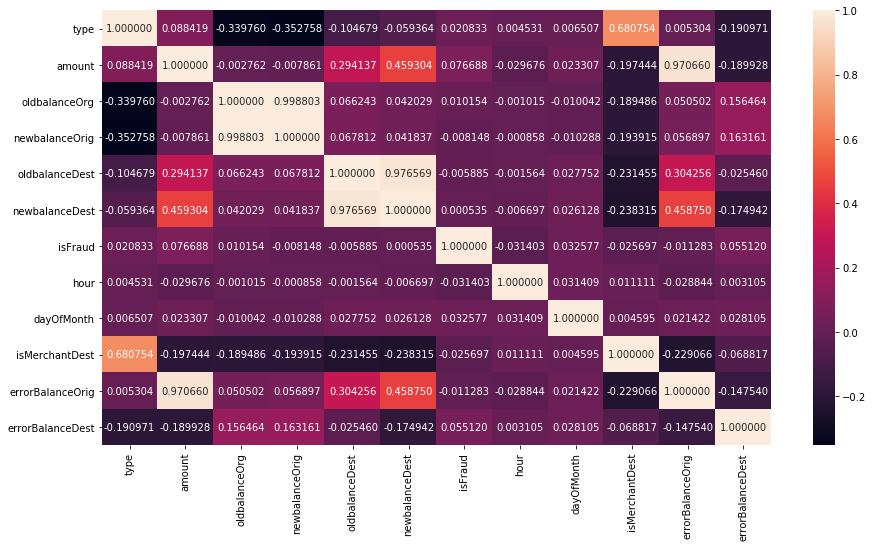

In [9]:
import matplotlib.pyplot as plt
corr = df_dataset.corr()

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, annot=True, fmt="f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)

### Now, we can select some features and generate the dataset
After a few rounds of training/testing and optimization, SHAP was applied to help us to select the best features

In [10]:
df_train = df_dataset[[
    'isFraud', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',    
    'newbalanceDest', 'hour', 'dayOfMonth', 'isMerchantDest',
        'errorBalanceOrig', 'errorBalanceDest' 
]].copy()
df_train.to_csv('data/train.csv', sep=',', header=None, index=None)
df_train.head(2)

,isFraud,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour,dayOfMonth,isMerchantDest,errorBalanceOrig,errorBalanceDest
0,0,3,9839.64,170136.0,160296.36,0.0,0.0,1,1,1,0.0,9839.64
1,0,3,1864.28,21249.0,19384.72,0.0,0.0,1,1,1,0.0,1864.28
